In [43]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

In [44]:
!pip install transformers

DEPRECATION: Loading egg at /Users/iresh/anaconda3/lib/python3.11/site-packages/fasttext-0.9.2-py3.11-macosx-11.1-arm64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


# Defining the Dataset Class

The len and getitem methods to return the length of the dataset and an item at specific index. 

In [45]:
class ReviewDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids= False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(label, dtype=torch.long)
    }

    

In [46]:
import pandas as pd
df = pd.read_csv('/path/to/cleanedWithAll.csv')
df

,Review,Rating,sentiStrength,sentiStrengthNormalized,vaderValue,textBlobValues,StandardRating,StandardVaderRatings,StandardTBRatings,new_reviews
0,"The ambience was good, food was quite good . h...",5,3,1,0.9664,0.660000,1,1,1,ambience good food quite good saturday lunch c...
1,Ambience is too good for a pleasant evening. S...,5,2,1,0.9360,0.606667,1,1,1,ambience good pleasant evening service prompt ...
2,A must try.. great food great ambience. Thnx f...,5,2,1,0.9186,0.540000,1,1,1,must try great food great ambience thnx servic...
3,Soumen das and Arun was a great guy. Only beca...,5,2,1,0.8591,0.500000,1,1,1,soumen das arun great guy behavior sincerety g...
4,Food is good.we ordered Kodi drumsticks and ba...,5,2,1,0.9201,0.577500,1,1,1,food goodwe ordered kodi drumsticks basket mut...
...,...,...,...,...,...,...,...,...,...,...
9949,Madhumathi Mahajan Well to start with nice cou...,3,2,1,0.9923,0.292500,0,1,1,madhumathi mahajan well start nice courteous s...
9950,This place has never disappointed us.. The foo...,5,3,1,0.9579,0.186174,1,1,1,place never disappointed us food courteous sta...
9951,"Bad rating is mainly because of ""Chicken Bone ...",2,1,1,0.9785,0.124535,-1,1,1,bad rating mainly chicken bone found veg food ...
9952,I personally love and prefer Chinese Food. Had...,4,2,1,0.9359,0.470000,1,1,1,personally love prefer chinese food couple tim...


In [47]:
df.dropna()

,Review,Rating,sentiStrength,sentiStrengthNormalized,vaderValue,textBlobValues,StandardRating,StandardVaderRatings,StandardTBRatings,new_reviews
0,"The ambience was good, food was quite good . h...",5,3,1,0.9664,0.660000,1,1,1,ambience good food quite good saturday lunch c...
1,Ambience is too good for a pleasant evening. S...,5,2,1,0.9360,0.606667,1,1,1,ambience good pleasant evening service prompt ...
2,A must try.. great food great ambience. Thnx f...,5,2,1,0.9186,0.540000,1,1,1,must try great food great ambience thnx servic...
3,Soumen das and Arun was a great guy. Only beca...,5,2,1,0.8591,0.500000,1,1,1,soumen das arun great guy behavior sincerety g...
4,Food is good.we ordered Kodi drumsticks and ba...,5,2,1,0.9201,0.577500,1,1,1,food goodwe ordered kodi drumsticks basket mut...
...,...,...,...,...,...,...,...,...,...,...
9949,Madhumathi Mahajan Well to start with nice cou...,3,2,1,0.9923,0.292500,0,1,1,madhumathi mahajan well start nice courteous s...
9950,This place has never disappointed us.. The foo...,5,3,1,0.9579,0.186174,1,1,1,place never disappointed us food courteous sta...
9951,"Bad rating is mainly because of ""Chicken Bone ...",2,1,1,0.9785,0.124535,-1,1,1,bad rating mainly chicken bone found veg food ...
9952,I personally love and prefer Chinese Food. Had...,4,2,1,0.9359,0.470000,1,1,1,personally love prefer chinese food couple tim...


In [48]:
# Shuffle the rows of the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

In [49]:
df

,Review,Rating,sentiStrength,sentiStrengthNormalized,vaderValue,textBlobValues,StandardRating,StandardVaderRatings,StandardTBRatings,new_reviews
0,Whats the difference between small medium and ...,1,-2,-1,-0.8218,-0.099702,-1,-1,-1,whats difference small medium large total wast...
1,Ordered chef's veg special thali from this pla...,5,4,1,0.9837,0.327296,1,1,1,ordered chefs veg special thali place awesome ...
2,very good,5,2,1,0.4927,0.910000,1,1,1,good
3,good,5,1,1,0.4404,0.700000,1,1,1,good
4,"Staff behavior are very bad. Our bill was 636,...",1,-1,-1,-0.8550,-0.805000,-1,-1,-1,staff behavior bad bill 636 took 836 reached h...
...,...,...,...,...,...,...,...,...,...,...
9949,"Ordered via Zomato. Poor packaging, the burger...",3,-1,-1,-0.4767,-0.500000,0,-1,-1,ordered via zomato poor packaging burger got s...
9950,Ordered Meals(Dal makhni + Rice + roti + Aloo ...,5,1,1,0.1761,0.100000,1,1,1,ordered mealsdal makhni rice roti aloo gobhi t...
9951,Pocket friendly and taste is ok. Ordered onlin...,3,1,1,0.6597,-0.217857,0,1,-1,pocket friendly taste ok ordered online chicke...
9952,Ordered a veg cheese grilled sandwich and a ve...,2,-3,-1,-0.4588,-0.200000,-1,-1,-1,ordered veg cheese grilled sandwich veg burger...


In [50]:
def conv(row):
    
    if row['Rating'] == 3.0:
        val = True
    elif row['Rating'] < 3.0:
        val = False
    else:
        val = False
    return val

In [51]:
df['tf'] = df.apply(conv, axis=1)
df

,Review,Rating,sentiStrength,sentiStrengthNormalized,vaderValue,textBlobValues,StandardRating,StandardVaderRatings,StandardTBRatings,new_reviews,tf
0,Whats the difference between small medium and ...,1,-2,-1,-0.8218,-0.099702,-1,-1,-1,whats difference small medium large total wast...,False
1,Ordered chef's veg special thali from this pla...,5,4,1,0.9837,0.327296,1,1,1,ordered chefs veg special thali place awesome ...,False
2,very good,5,2,1,0.4927,0.910000,1,1,1,good,False
3,good,5,1,1,0.4404,0.700000,1,1,1,good,False
4,"Staff behavior are very bad. Our bill was 636,...",1,-1,-1,-0.8550,-0.805000,-1,-1,-1,staff behavior bad bill 636 took 836 reached h...,False
...,...,...,...,...,...,...,...,...,...,...,...
9949,"Ordered via Zomato. Poor packaging, the burger...",3,-1,-1,-0.4767,-0.500000,0,-1,-1,ordered via zomato poor packaging burger got s...,True
9950,Ordered Meals(Dal makhni + Rice + roti + Aloo ...,5,1,1,0.1761,0.100000,1,1,1,ordered mealsdal makhni rice roti aloo gobhi t...,False
9951,Pocket friendly and taste is ok. Ordered onlin...,3,1,1,0.6597,-0.217857,0,1,-1,pocket friendly taste ok ordered online chicke...,True
9952,Ordered a veg cheese grilled sandwich and a ve...,2,-3,-1,-0.4588,-0.200000,-1,-1,-1,ordered veg cheese grilled sandwich veg burger...,False


Converting the PandasDataframe into a list in Python allows to use the values attribute of the Dataframe Object. It returns a NumPy array containing the data in the Dataframe. then the Numpy array is converted to a list using tolist() method.

In [52]:
# loading thr data into two separate lists: tweet descriptions and labels

texts = df['Review'].values.tolist()
labels = df['tf'].values.tolist()
labels

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 Fa

In [53]:
#intiate the bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#setting max sequence length
max_len = 120 #max characters

#creating an instance of the dataset
dataset = ReviewDataset(texts, labels, tokenizer, max_len)

# Calculate the size of the training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create separate data loaders for the training and validation sets
batch_size=32

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [54]:
train_size = len(train_dataset)
print("Training dataset size:", train_size)

Training dataset size: 7963


In [55]:
data_loader

# Bert Model for Sequence Classification

BertForSequenceClassification class is a pretrained Bert Model that has an additional classification layer on top of standard Bert architecture.

num_labels: parameter that specifies the number of labels to predict. 

When the BertForSequenceClassification oblect is initialized, the num_labels parameter tells the model how many different labels it should predict. In this case in is 2, as it is binary classification.

This parameter initializes the final classification layer of the model. The layer has num_labels output units, each corresponding to one possible labels. During training, the model learns to assign a probability to each label for a given input sequence, and the label with the highest probability is selected as the predicted label.

In [56]:
#initialze bert model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

#defining optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/iresh/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [57]:
    #defining no.of epochs
    num_epochs = 15

    #set the device to run on (GPU if available, otherwise CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)

    #set the no.of training steps
    total_steps = len(train_loader) * num_epochs

    #set learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    #defining loss function
    loss_fn = torch.nn.CrossEntropyLoss()

    #train the model
    for epoch in range(num_epochs):
      print(f"Epoch {epoch+1}/{num_epochs}")
      for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
    

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/iresh/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


##Model Evaluation

In [58]:
import numpy as np

model.eval()

# initialize variables to store predictions and labels
preds = []
labels = []

# turn off gradients during evaluation
with torch.no_grad():
    # iterate over validation data loader
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits.data, 1)

        # store predictions and labels
        preds.extend(predicted.cpu().numpy())
        labels.extend(batch['labels'].cpu().numpy())

# calculate accuracy
correct = (np.array(preds) == np.array(labels)).sum()
accuracy = correct / len(labels)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4445


In [59]:
# Tokenize input text
input_text = "food is excellent, place was cozy."
input_ids = tokenizer.encode(input_text, add_special_tokens=True)
input_ids = torch.tensor(input_ids)

# Make prediction
model.eval()
with torch.no_grad():
    outputs = model(input_ids.unsqueeze(0))
    logits = outputs[0]
    probabilities = torch.softmax(logits, dim=1)
    predicted_label = torch.argmax(probabilities, dim=1)

print(predicted_label.item())

0


In [60]:
# Tokenize input text
input_text = "good food"
input_ids = tokenizer.encode(input_text, add_special_tokens=True)
input_ids = torch.tensor(input_ids)

# Make prediction
model.eval()
with torch.no_grad():
    outputs = model(input_ids.unsqueeze(0))
    logits = outputs[0]
    probabilities = torch.softmax(logits, dim=1)
    predicted_label = torch.argmax(probabilities, dim=1)

print(predicted_label.item())

1


## Pushing the Model to Huggingface Hub

In [61]:
!pip install huggingface_hub

DEPRECATION: Loading egg at /Users/iresh/anaconda3/lib/python3.11/site-packages/fasttext-0.9.2-py3.11-macosx-11.1-arm64.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


A huggingface account was created and a token was created giving permission for write access. 

In [62]:
from huggingface_hub import notebook_login

notebook_login()

In [63]:
model.push_to_hub("bert-base-uncased-review1")

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Iresh88/bert-base-uncased-review1/commit/02c52447cb131ec95a156b5c2d9f8dfb84a1ae02', commit_message='Upload BertForSequenceClassification', commit_description='', oid='02c52447cb131ec95a156b5c2d9f8dfb84a1ae02', pr_url=None, pr_revision=None, pr_num=None)

In [64]:
tokenizer.push_to_hub("bert-base-uncased-review1")

CommitInfo(commit_url='https://huggingface.co/Iresh88/bert-base-uncased-review1/commit/34646004f17e9415ed67506bfe3a92d1ce6f49d1', commit_message='Upload tokenizer', commit_description='', oid='34646004f17e9415ed67506bfe3a92d1ce6f49d1', pr_url=None, pr_revision=None, pr_num=None)

## Model Evaluation 

Once the model is registered with the Hugging Face hub, it can be loaded using the from_pretrained() method of BertForSequenceClassification. 

In [65]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('Iresh88/bert-base-uncased-review1')


In [66]:
import numpy as np

model.eval()

# initialize variables to store predictions and labels
preds = []
labels = []
probs = []

# turn off gradients during evaluation
with torch.no_grad():
    # iterate over validation data loader
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # get model predictions
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        _, predicted = torch.max(logits.data, 1)

        # store predictions and labels
        preds.extend(predicted.cpu().numpy())
        labels.extend(batch['labels'].cpu().numpy())
        probs.extend(probabilities[:, 1].cpu().numpy())

# calculate accuracy
correct = (np.array(preds) == np.array(labels)).sum()
accuracy = correct / len(labels)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4445


## Plotting the Confusion Matrix

Accuracy: 44.45%
F1 Score: 0.22980501392757663
Recall: 0.625
Precision: 0.1407849829351536
Sensitivity: 0.625
Specificity: 0.4169079328314997


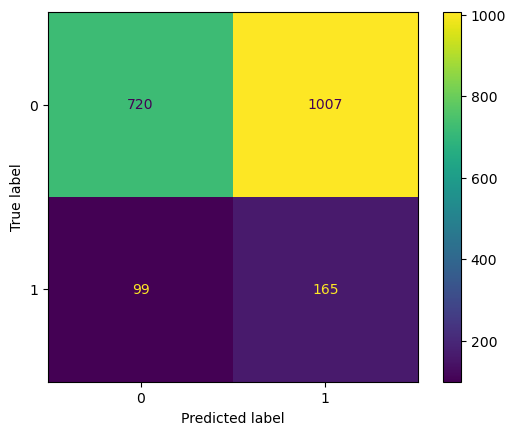

In [67]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# generate confusion matrix
bert_model_confusion_matrix = confusion_matrix(labels, preds)

#Extract true postive, true negative, false positive and false positive
tn, fp, fn, tp = bert_model_confusion_matrix.ravel() 

#calculate accuracy, recall, precision, sensitivity and specificity
bert_model_accuracy = accuracy_score(labels, preds)
bert_model_f1_score = f1_score(labels, preds)
bert_model_recall = tp / (tp + fn)
bert_model_precision = tp / (tp + fp)
bert_model_sensitivity = tp / (tp + fn)
bert_model_specificity = tn / (tn + fp)

#print the scores
print("Accuracy: {:.2f}%".format(bert_model_accuracy * 100))
print("F1 Score:", bert_model_f1_score)
print("Recall:", bert_model_recall)
print("Precision:", bert_model_precision)
print("Sensitivity:", bert_model_sensitivity)
print("Specificity:", bert_model_specificity)

#plot confusion matrix for decision tree model
# Display the confusion matrix as a plot
disp = ConfusionMatrixDisplay(confusion_matrix=bert_model_confusion_matrix)
disp.plot()
plt.show()

## Plotting AUC ROC Curve

ROC AUC: 0.5165267322910635
AUC Score: 0.5165267322910635


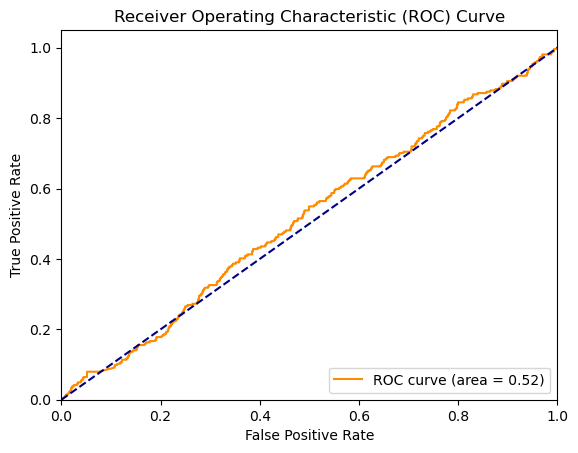

In [68]:
# import required libraries
from sklearn.metrics import roc_curve, auc, roc_auc_score

# predict probabilities
y_pred_bert_prob = probs

# calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(labels, y_pred_bert_prob)

# calculate ROC AUC
roc_auc_score = roc_auc_score(labels, y_pred_bert_prob)

# print ROC AUC
print("ROC AUC:", roc_auc_score)

# calculate AUC
roc_auc = auc(fpr, tpr)

# print AUC score
print("AUC Score:", roc_auc)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()